# FIGARO: an introductive guide

This notebook shows how to use FIGARO, *Fast Inference for GW Astronomy, Research & Observations*.

## 1D probability density

We will start from a simple problem: inferring a 1D probability density given a set of samples drawn from it.
Let's draw some samples from a Gaussian distribution.

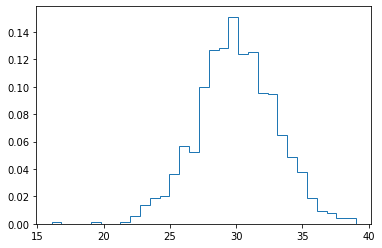

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm

mu = 30
sigma = 3
n_samps = 1000
dist = norm(mu, sigma)

samples = dist.rvs(n_samps)

n, b, p = plt.hist(samples, bins = int(np.sqrt(len(samples))), histtype = 'step', density = True)

FIGARO contains a class designed to infer probability densities given a set of samples.

In order to instantiate the class, we need to specify the boundaries of the distribution.
We will assume that our probability density is bounded between 10 and 50.

In [2]:
from figaro.mixture import DPGMM

x_min = 10
x_max = 50

mix = DPGMM([[x_min, x_max]])

Please note that the boundaries must be passed as a 2D array. This is to ensure that the very same syntax holds for multidimensional distributions too.

The idea is that the algorithm *learns* the shape of the probability density from the available samples, one at a time: every new sample adds a piece of information to the inference. Therefore, we need to pass the samples to our mixture one at a time in order to draw a single realisation of the Dirichlet Process.

In [3]:
for s in tqdm(samples):
    mix.add_new_point(s)

100%|██████████████████████████████████████| 1000/1000 [00:07<00:00, 127.34it/s]


Now that our mixture knows the shape of the distribution, we can build the probability density and initialise the mixture:

In [4]:
rec = mix.build_mixture()
mix.initialise()

Let's have a look at this reconstruction. `dist` contains the realisation we just drew, with some useful methods.

In [5]:
[method_name for method_name in dir(rec)
                  if callable(getattr(rec, method_name)) and not method_name.startswith('_')]

['evaluate_log_mixture', 'evaluate_mixture', 'sample_from_dpgmm']

`evaluate_mixture` and `evaluate_log_mixture` take a 2D array and return, respectively, the probability and the log_probability of the inferred distribution, while `sample_from_dpgmm` takes the number of desiderd samples and returns an array of draws.

We now want to evaluate the probability density over the interval $[x_{min},x_{max}]$.   
**WARNING: FIGARO uses a coordinate change that is singular at boundaries. Be careful not to evaluate the mixture on or outside the boundaries. This will result in infs or NaNs.**

In [6]:
x = np.linspace(x_min, x_max, 1002)[1:-1]
p = rec.evaluate_mixture(np.atleast_2d(x).T)

Let's compare the reconstruction with the samples and with the true distribution:

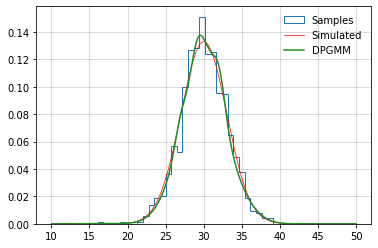

In [7]:
n, b, t = plt.hist(samples, bins = int(np.sqrt(len(samples))), histtype = 'step', density = True, label = 'Samples')
plt.plot(x, dist.pdf(x), color = 'red', lw = 0.7, label = 'Simulated')
plt.plot(x, p, color = 'forestgreen', label = 'DPGMM')
plt.legend(loc = 0, frameon = False)
plt.grid(alpha = 0.6)

This is a *single* realisation from the Dirichlet Process. In order to properly explore the distribution space, we need a set of draws: therefore we need to repeat the exercise of training the DPGMM for every new sample we want. 

The DPGMM class contains a method that is a wrapper for the `for` loop we wrote before, `DPGMM.density_from_samples()`.

In [8]:
n_draws = 100
draws = []

for _ in tqdm(range(n_draws)):
    np.random.shuffle(samples)
    mix.density_from_samples(samples)
    draws.append(mix.build_mixture())
    mix.initialise()

100%|█████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


Calling the `initialise()` method is mandatory because the class needs to *forget* the samples we gave it before starting building a new mixture.

With the set of draws we have, we can compute median and credible regions for the probability distribution.

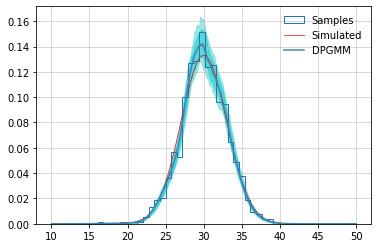

In [9]:
probs = np.array([d.evaluate_mixture(np.atleast_2d(x).T) for d in draws])

percentiles = [50, 5, 16, 84, 95]
p = {}
for perc in percentiles:
    p[perc] = np.percentile(probs.T, perc, axis = 1)
N = p[50].sum()*(x[1]-x[0])
for perc in percentiles:
    p[perc] = p[perc]/N

n, b, t = plt.hist(samples, bins = int(np.sqrt(len(samples))), histtype = 'step', density = True, label = 'Samples')
plt.fill_between(x, p[95], p[5], color = 'mediumturquoise', alpha = 0.5)
plt.fill_between(x, p[84], p[16], color = 'darkturquoise', alpha = 0.5)
plt.plot(x, dist.pdf(x), color = 'red', lw = 0.7, label = 'Simulated')
plt.plot(x, p[50], color = 'steelblue', label = 'DPGMM')
plt.legend(loc = 0, frameon = False)
plt.grid(alpha = 0.6)   

The same plot can be obtained with the dedicated method:

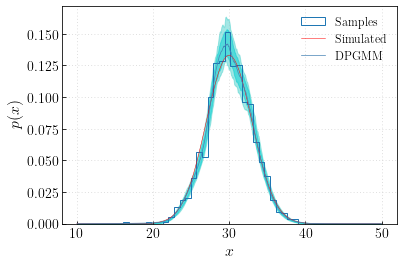

In [10]:
from figaro.utils import plot_median_cr
plot_median_cr(draws,
               injected = dist.pdf,
               samples  = samples,
               save     = False,
               )

The draws are uncorrelated from each other. The autocorrelation function is:

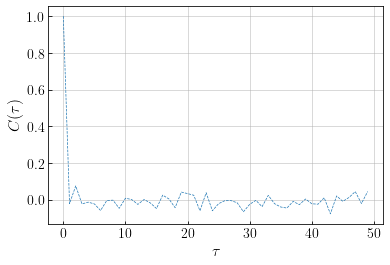

In [11]:
from figaro.diagnostic import autocorrelation
autocorrelation(draws, bounds = [20, 40], save = False, show = True)

## Multidimensional probability density

Multidimensional probability densities can be inferred using the same functions.

Let's generate some data from a bivariate Gaussian distribution:

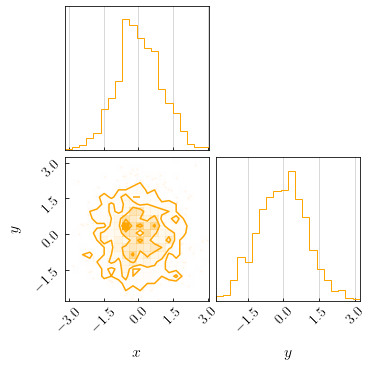

In [15]:
from scipy.stats import multivariate_normal as mn
from corner import corner

n_samps = 1000
samples = mn(np.zeros(2), np.identity(2)).rvs(n_samps)

c = corner(samples, color = 'orange', labels = ['$x$','$y$'], hist_kwargs={'density':True})

The only difference with the previous case is that the mixture needs to be instantiated specifying the bounds for both dimensions.

In [16]:
x_min = -5
x_max = 5
y_min = -5
y_max = 5

mix_2d = DPGMM([[x_min, x_max],[y_min, y_max]])

The inference runs exactly as before:

In [17]:
for s in tqdm(samples):
    mix_2d.add_new_point(s)
rec = mix_2d.build_mixture()
mix_2d.initialise()

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 730.31it/s]


Let's compare the initial samples with a set of samples drawn from the recovered distribution.

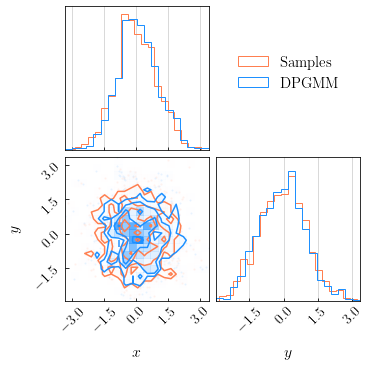

In [18]:
mix_samples = rec.sample_from_dpgmm(n_samps)

c = corner(samples, color = 'coral', labels = ['$x$','$y$'], hist_kwargs={'density':True, 'label':'$\mathrm{Samples}$'})
c = corner(mix_samples, fig = c, color = 'dodgerblue', labels = ['$x$','$y$'], hist_kwargs={'density':True, 'label':'$\mathrm{DPGMM}$'})
plt.legend(loc = 0,frameon = False,fontsize = 15, bbox_to_anchor = (1-0.05, 1.8))

Multiple draws:

In [19]:
n_draws = 100
draws = []

for _ in tqdm(range(n_draws)):
    np.random.shuffle(samples)
    mix_2d.density_from_samples(samples)
    draws.append(mix_2d.build_mixture())
    mix_2d.initialise()

100%|█████████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/it]


## Hierarchical inference

Let's assume to have a set of samples $\{x_1,\ldots,x_k\}$ from some probability density $F(x)$. Around each $x_i$, another process generated a set of samples $\mathbf{y}_i = \{y_1^i,\ldots,y_n^i\}$ according to some distribution $f_i(y|x_i)$.   
To give a bit of context, $\{x_1,\ldots,x_k\}$ could be the true masses of the black holes observed by LIGO and Virgo drawn from the mass function $F(x)$ and each $\mathbf{y}_i$ could be the set of single-event primary mass posterior samples drawn from the posterior samples $f_i(y|x_i)$.

In this section we'll see how to use FIGARO to infer $F(x)$ using $\{\mathbf{y}_1,\ldots,\mathbf{y}_k\}$.
In the following example, both $F(x)$ and $f_i(y|x_i)$ are Gaussian distributions.

In [20]:
mu = 30
sigma = 5
n_evs = 50
n_post_samps = 1000

mass_function = norm(mu, sigma)
true_masses = mass_function.rvs(n_evs)

single_event_posteriors = [norm(M, np.random.uniform(1,3)).rvs(n_post_samps) for M in true_masses]

First of all, we need to reconstruct the $k$ probability densities $f_i$. For each $y_i$, we can use the DPGMM class.
A proper analysis would require to draw multiple realisations for each posterior distribution. In this example, for the sake of time, we will draw only a handful of realisations for each event.

In [22]:
n_draws = 50
x_min = 1
x_max = 70
mix = DPGMM([[x_min, x_max]])

posteriors = []
for event in tqdm(single_event_posteriors, desc = 'Events'):
    for _ in range(n_draws):
        draws = []
        mix.density_from_samples(event)
        draws.append(mix.build_mixture())
        mix.initialise()
    posteriors.append(draws)

Events: 100%|███████████████████████████████████| 50/50 [12:56<00:00, 15.54s/it]


Once we have the single-event posterior reconstructions, we need the HDPGMM class:

In [23]:
from figaro.mixture import HDPGMM
hier_mix = HDPGMM([[x_min, x_max]])

The methods for this new class are the same we used before.

In [24]:
n_draws_hier = 50
hier_draws = []

for _ in tqdm(range(n_draws_hier)):
    np.random.shuffle(posteriors)
    hier_mix.density_from_samples(posteriors)
    hier_draws.append(hier_mix.build_mixture())
    hier_mix.initialise()

100%|███████████████████████████████████████████| 50/50 [05:00<00:00,  6.02s/it]


In the same fashion, we can plot the recovered distribution using the dedicated method:

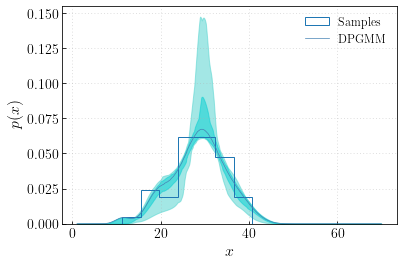

In [25]:
plot_median_cr(hier_draws,
               samples  = true_masses,
               save     = False,
               )